In [6]:
# Import libraries and data

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
# Define function for model comparison

def collect_metrics(y_true, y_pred, method_name):
    return {
        'method': method_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }

In [4]:
# Prepare data for model fitting

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

# One-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Hyper-parameter tuning using grid search

# Define data pipeline and parameter grid
param_grid = {
    'hidden_layer_sizes': [
        (50,), (100,), (150,),
        (100, 50), (150, 75),
        (100, 50, 25)
    ],
    'activation': ['relu', 'tanh'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'solver': ['adam'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'max_iter': [5000]
}

ann = MLPClassifier(random_state=49)

grid_search = GridSearchCV(
    ann,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

# Use best estimator
best_ann = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.0001, 'max_iter': 5000, 'solver': 'adam'}
Best F1 Score: 0.7597529742485215


        method  accuracy  precision    recall  f1_score
0  Final Train   0.99651   0.996700  0.993421  0.995058
1   Final Test   0.80000   0.722973  0.703947  0.713333


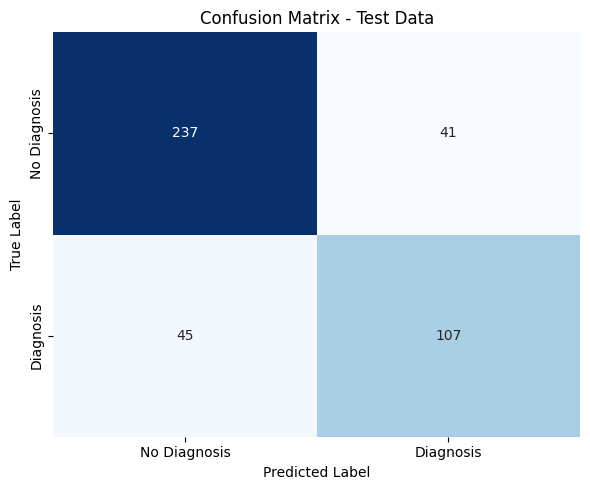

In [8]:
# Stratified K-Fold cross-validation on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=49)
for train_idx, val_idx in cv.split(X_scaled, y):
    X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    best_ann.fit(X_tr, y_tr)
    _ = best_ann.predict(X_val)

X_test = test.drop('Diagnosis', axis=1)
y_test = test['Diagnosis']

# Perform one-hot encoding on the test set
X_test = pd.get_dummies(X_test, drop_first=True)

# Reindex the test set
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Scale the test data using the same scaler fitted on the training set
X_test_scaled = scaler.transform(X_test)

# Fit the final tuned model on the full training dataset
best_ann.fit(X_scaled, y)

# Generate predictions on the full training set and the test set
y_train_pred_final = best_ann.predict(X_scaled)
y_test_pred_final = best_ann.predict(X_test_scaled)

# Collect performance metrics
final_train_metrics = collect_metrics(y, y_train_pred_final, method_name="Final Train")
final_test_metrics  = collect_metrics(y_test, y_test_pred_final, method_name="Final Test")

# Combine final performance metrics
results = [final_train_metrics, final_test_metrics]
results_df = pd.DataFrame(results)
print(results_df)

# Compute the confusion matrix for the test predictions.
cm = confusion_matrix(y_test, y_test_pred_final)

# Define labels
labels = ['No Diagnosis', 'Diagnosis']

# Visualize the confusion matrix as a heatmap.
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Data')
plt.tight_layout()
plt.show()


        method  accuracy  precision    recall  f1_score   ROC AUC
0  Final Train   0.99651   0.996700  0.993421  0.995058  0.995810
1   Final Test   0.80000   0.722973  0.703947  0.713333  0.778233


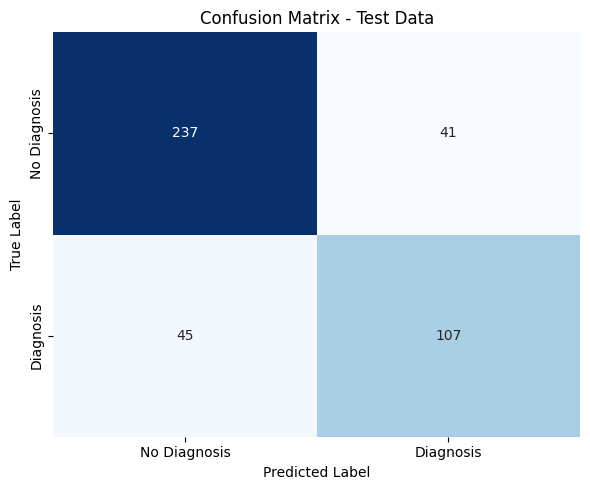

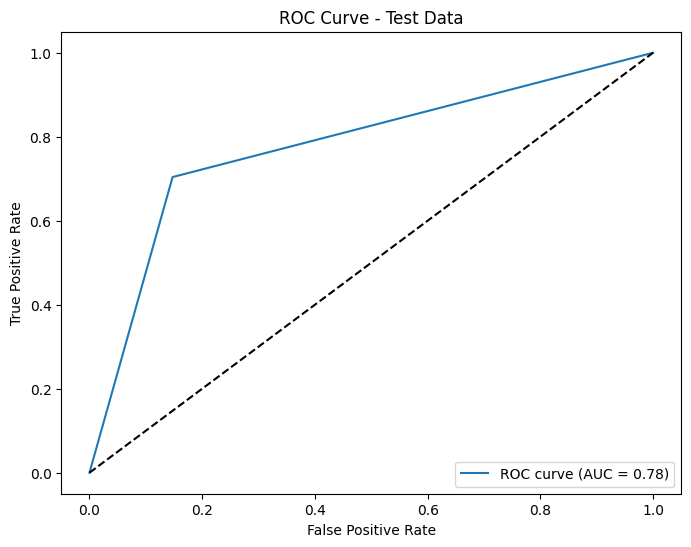

In [7]:
# Stratified K-Fold cross-validation on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=49)
for train_idx, val_idx in cv.split(X_scaled, y):
    X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    best_ann.fit(X_tr, y_tr)
    _ = best_ann.predict(X_val)

X_test = test.drop('Diagnosis', axis=1)
y_test = test['Diagnosis']

# Perform one-hot encoding on the test set
X_test = pd.get_dummies(X_test, drop_first=True)

# Reindex the test set
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Scale the test data using the same scaler fitted on the training set
X_test_scaled = scaler.transform(X_test)

# Fit the final tuned model on the full training dataset
best_ann.fit(X_scaled, y)

# Generate probabilities on the full training set and the test set
y_train_probs = best_ann.predict(X_scaled).ravel()
y_test_probs  = best_ann.predict(X_test_scaled).ravel()

# Convert probabilities to binary predictions using a 0.5 threshold
y_train_pred_final = (y_train_probs > 0.5).astype(int)
y_test_pred_final  = (y_test_probs > 0.5).astype(int)

# Collect performance metrics
final_train_metrics = collect_metrics(y, y_train_pred_final, method_name="Final Train")
final_test_metrics  = collect_metrics(y_test, y_test_pred_final, method_name="Final Test")
final_train_metrics["ROC AUC"] = roc_auc_score(y, y_train_probs)
final_test_metrics["ROC AUC"]  = roc_auc_score(y_test, y_test_probs)

# Combine final performance metrics
results = [final_train_metrics, final_test_metrics]
results_df = pd.DataFrame(results)
print(results_df)

# Compute the confusion matrix for the test predictions.
cm = confusion_matrix(y_test, y_test_pred_final)

# Define labels
labels = ['No Diagnosis', 'Diagnosis']

# Visualize the confusion matrix as a heatmap.
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Data')
plt.tight_layout()
plt.show()

# Plot ROC curve for the test set.
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = roc_auc_score(y_test, y_test_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Data")
plt.legend(loc="lower right")
plt.show()
